# Molecular dynamics in SchNetPack (experimental)

In the [previous tutorial](tutorial_03_force_models.ipynb) we have covered how to train machine learning models on molecular forces and use them for basic molecular dynamics (MD) simulations with the SchNetPack ASE interface.

All these simulations can also be carried out using the native MD package available in SchNetPack.
The main ideas behind integrating MD functionality directly into SchNetPack are:
- improve performance by reducing the communication overhead between ML models and the MD code and adding the option to use GPUs
- adding extended functionality, such as sampling algorithms and ring polymer MD
- providing a modular MD environment for easy development and interfacing

In the following, we first introduce the general structure of the SchNetPack-MD package.
Then the simulation from the previous tutorial will be used as an example to demonstrate how to implement basic MD with SchNetPack-MD.
Having done so, we will cover a few advanced simulation techniques, such as ring polymer MD.

Finally, we will show how all of these different simulations can be accessed via an input file.

## Getting started

Before we can begin with the main tutorial, some setup is required.
First, we generate a directory for holding our simulations:

In [1]:
import os

md_workdir = 'mdtut'

# Gnerate a directory of not present
if not os.path.exists(md_workdir):
    os.mkdir(md_workdir)

Since we want to run MD simulations, we need a SchNetPack model trained on forces and a molecular structure as a starting point.
In principle, we could use the ethanol model and structure generated in the previous tutorial.
However, the model trained in the force tutorial was only intended as a demonstration and is not the most accurate.


Instead, we will use a sample ethanol structure, as well as a fully converged SchNet model of ethanol provided with the data used for testing SchNetPack for this tutorial:

In [2]:
import schnetpack as spk

# Get the parent directory of SchNetPack
spk_path = os.path.abspath(os.path.join(os.path.dirname(spk.__file__), '../..'))

# Get the path to the test data
test_path = os.path.join(spk_path, 'tests/data')

# Load model and structure
model_path = os.path.join(test_path, 'test_md_model.model')
molecule_path = os.path.join(test_path, 'test_molecule.xyz')

## MD in SchNetPack

In general, a MD code needs to carry out several core tasks during each simulation step. 
It has to keep track of the positions $\mathbf{R}$ and momenta $\mathbf{p}$ of all nuclei, compute the forces $\mathbf{F}$ acting on the nuclei and use the latter to integrate Newton's equations of motion.

<img src="tutorials_figures/md_flowchart.svg" width="200" style="padding: 5px 15px; float: left;">

The overall workflow used in the SchNetPack MD package is sketched in the figure to the left.
As can be seen, the various tasks are distibuted between different modules. 

The `System` class contains all information on the present state of the simulated system (e.g. nuclear positons and momenta).
This is a good point to mention, that internally the MD package uses atomic units for all properties.

The `Integrator` computes the positions and momenta of the next step and updates the state of the system accordingly.

In order to carry out this update, the nuclear forces are required. 
These are computed with a `Calculator`, which takes the positions of atoms and returns the corresponding forces.
Typically, the `Calculator` consists of a previously trained machine learning model.

All these modules are linked together in the `Simulator` class, which contains the main MD loop and calls the three previous modules in the correct order.

We will now describe the different components of the MD package in more detail and give an example of how to set up a short MD simulation of an ethanol molecule.

### System

As stated previously, `System` keeps track of the state of the simulated system and contains the atomic positions $\mathbf{R}$ and momenta $\mathbf{p}$, but also e.g. atom types and computed molecular properties.

A special property of SchNetPack-MD is the use of multdimensional tensors to store the system information (using the `torch.Tensor` class).
This makes it possible to make full use of vectorization and e.g. simulate several different molecules as well as different replicas of a molecule in a single step.
The general shape of these system tensors is $N_\textrm{replicas} \times N_\textrm{molecules} \times N_\textrm{atoms} \times \ldots$, where the first dimension is the number of replicas of the same molecule (e.g. for ring polymer MD), the second runs over the different molecules simulated (e.g. fragments of different size for sampling) and the third over the maximum number of atoms present in any system.

In order to initialize a `System`, first the number of replicas needs to be given. Here, we want to perform a standard MD and $N_\mathrm{replicas}=1$.
In addition, one can specify the device used for the computation.
Afterwards, the molecules which should be simulated need to be loaded.
These can be read directly from a XYZ-file via the `load_molecules_from_xyz` function. 
$N_\mathrm{molecules}$ is determined automatically based on the number of structures found in this file.
In our present case, the loaded files containes the structure of a single ethanol.

In [3]:
from schnetpack.md import System

# Device
md_device='cpu'
# Number of molecular replicas
n_replicas = 1

# Initialize the system
md_system = System(n_replicas, device=md_device)

# Load the structure
md_system.load_molecules_from_xyz(molecule_path)

Right now, all system momenta are set to zero. 
For practical purposes, one usually wants to draw the momenta from a distribution corresponding to a certain temperature.
This can be done via an `Initializer`, which takes the temperature in Kelvin as an input. For this example, we use a Maxwell&mdash;Boltzmann initialization:

In [4]:
from schnetpack.md import MaxwellBoltzmannInit

system_temperature = 300 # Kelvin

# Set up the initializer
md_initializer = MaxwellBoltzmannInit(
    system_temperature,
    remove_translation=True,
    remove_rotation=True)

# Initialize momenta of the system
md_initializer.initialize_system(md_system)

/home/mitx/pbc_test/schnetpack/src/schnetpack/md/utils/basic_utils.py:40: UserWarning: torch.gesv is deprecated in favour of torch.solve and will be removed in the next release. Please use torch.solve instead.
  tensor_inv, _ = torch.gesv(eye, tensor)


Here, we have also removed all translational and rotational components of the momenta via the appropriate keyword.

### Integrator

Having set up the system in such a manner, one needs to specify how the equations of motion should be propagated.
Currently, there are two integration schemes implemented in SchNetPack:
- a Velocity Verlet integrator which evolves the system in a purely classical manner and
- a ring polymer integrator which is able to model a certain degree of nuclear quantum effects

For demonstration purposes, we will first focus on a purely classical MD using the Velocity Verlet algorithm.
An example on how to use ring polymer MD in SchNetPack and potential benefits will be given later in the tutorial.
To initialize the integrator, one has to specify the length of the timestep $\Delta t$ used for integration in units of femtoseconds.
A common value for classical MD is $\Delta t = 0.5$&thinsp;fs.


In [5]:
from schnetpack.md.integrators import VelocityVerlet

time_step = 0.5 # fs

# Setup the integrator
md_integrator = VelocityVerlet(time_step)

### Calculator

The only ingredient missing for simulating our system is a `Calculator` to compute molecular forces and other properties.
A `Calculator` can be thought of as an interface between a computation method (e.g. a machine learning model) and the MD code in SchNetPack.
SchNetPack comes with several predefined calculators and also offers the possibility to implement custom calculators.

Right now, we are only interested in using a model trained with SchNetPack, hence we use the `SchnetPackCalculator`.
First, we have to load the stored model with Torch and move it to the computation device defined before.
To initialize the `SchnetPackCalculator`, we have to pass it the loaded model.
Similar as for the ASE interface in the [last tutorial](tutorial_03_force_models.ipynb), we have to tell the calculator which properties to compute, how the forces are called in the output.
Since the whole SchNetPack-MD package uses atomic units, it is also necessary to specify which units the calculator expects for the positions (`position_conversion`) and which units it uses for the returned forces (`force_conversion`).


For the first two points, we can make use of the SchNetPack properties definitions. With regards to units, the current calculator uses &#8491 for positions and kcal/mol/&#8491; for the forces. The conversion factors can either be given as a number or as a string. 

In [6]:
from schnetpack.md.calculators import SchnetPackCalculator
from schnetpack.atomistic.properties import Properties
import torch

# Load the stored model
md_model = torch.load(model_path, map_location=md_device).to(md_device)

# Generate the calculator
md_calculator = SchnetPackCalculator(
    md_model,
    required_properties=[Properties.energy, Properties.forces],
    force_handle=Properties.forces,
    position_conversion='A',
    force_conversion='kcal/mol/A'
)

/home/mitx/anaconda3/envs/schnet_debug/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'schnetpack.representation.schnet.SchNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/mitx/anaconda3/envs/schnet_debug/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'schnetpack.atomistic.output_modules.Atomwise' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


### Simulator (bringing it all together)

With our molecular system, a machine learning calculator for the forces and an integrator at hand, we are almost ready carry out MD simulations.
The last step is to pass all these ingredients to a `Simulator`.
The `Simulator` performs the actual MD simulations, looping over a series of time steps and calling the individual modules in the right order:

In [7]:
from schnetpack.md import Simulator

md_simulator = Simulator(md_system, md_integrator, md_calculator)

To carry out a simulation, one needs to call the `simulate` function with an integer argument specifying the number of desired simulation steps.

For example, a MD simulation of our ethanol molecule for 100 time steps (50&thinsp;fs) can be done via:

In [8]:
n_steps = 100

md_simulator.simulate(n_steps)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 61.51it/s]


Since the `Simulator` keeps track of the state of the dynamics and the system, we can call it repeatetly to get longer trajectories.

In [9]:
md_simulator.simulate(n_steps)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 64.81it/s]


The actual number of steps is stored in the `step` variable of the `Simulator` class.

In [10]:
print("Total number of steps:", md_simulator.step)

Total number of steps: 200


Although we are now able to run a full-fledged MD simulation, there is one major problem with the current setup:
we do not collect any information during the simulation, such as nuclear positions.
This means, that we currently have no way of analyzing what happened during the MD trajectory.


This &mdash; and many other things &mdash; can be done in the SchNetPack-MD package using so-called simulation hooks.



## Simulation hooks


Simulation hooks follow the same concept as the hooks used in the SchNetPack `Trainer` class covered [previously](tutorial_02_qm9.ipynb).
They can be thought as instructions for the `Simulator`, which are performed at certain points during each MD step.
Simulation hooks can be used to tailor a simulation to ones need, contributing to the customizability of the SchNetPack-MD package. 

<img src="tutorials_figures/integrator.svg" width="370" style="padding: 20px 20px; float: left">

The diagram to the left shows how a single MD step of the `Simulator` is structured in detail and at which points hooks can be applied.
Depending on which time they are called and which actions they encode, simulation hooks can achieve a wide range of tasks.

If they are introduced before and after each integration half-step, they can e.g. be used to control the temperature of the system in the form of thermostats.

When acting directly after the computation of the forces done by the `Calculator`, simulation hooks can be used to control sampling.
At this point, enhanced sampling schemes such as metadynamics and accelerated MD can be implemented, which modify the forces and potential energies of the system.
It is also possible to introduce active learning for automatically generating machine learning models in this way.

Finally, when called after the second integration step, simulation hooks can be used to collect and store information on the system, which can then be used for analysis.

Multiple hooks can be passed to a simulator at any time, which makes it possible to control a simulation in various manners.
In the following, we will demonstrate how to apply a thermostat to the above simulation and how data collection can be done in SchNetPack.

### Adding a Thermostat

As mentioned in the [force tutorial](tutorial_03_force_models.ipynb), thermostats are used to keep the fluctuations of the kinetic energy of a system (temperature) close to a predefined average.
Simulations employing thermostats are referred to as canonical ensemble or $NVT$ simulations, since they keep the number of particles $N$, the volume $V$ and the average temperature $T$ constant.

Last time, we used a Langevin thermostat to regulate the temperature of our simulation.
This thermostat (and many others) is also available in SchNetPack and can be used via

In [11]:
from schnetpack.md.simulation_hooks import thermostats

# Set temperature and thermostat constant
bath_temperature = 300 # K
time_constant = 100 # fs

# Initialize the thermostat
langevin = thermostats.LangevinThermostat(bath_temperature, time_constant)

INFO:root:Using Langevin thermostat


In case of the Langevin thermostat, a bath temperature (in Kelvin) and a time constant (in fs) have to be provided.
The first regulates the temperature the system is kept at, the second how fast the thermostat adjusts the temperature. 

Finally, we begin collecting the simulation hooks we want to pass to the simulator.

In [12]:
simulation_hooks = [
    langevin
]

### Collecting Data and storing Checkpoints

The primary way to store simulation data in the SchNetPack-MD package is via the `FileLogger` class.
A `FileLogger` collects data during the MD and stores it to a database in HDF5 format.
The type of data to be collected is specified via so-callled `DataStreams`, which are passed to the `FileLogger`.
The data streams currently available in SchNetPack are:
- `MoleculeStream`: Stores positions and velocities during all simulation steps
- `PropertyStream`: Stores all properties predicted by the calculator
- `SimulationStream`: Collects information on the kinetic energy and system temperature (this can be also done via postprocessing when using the `MoleculeStream`)
By default, the `MoleculeStream` and `PropertyStream` are used.

To reduce overhead due to writing to disk, the `FileLogger` first collects information for a certain number of steps into a buffer, which it then writes to the database at once.

The `FileLogger` is initialized by specifying the name of the target database, the size of the buffer and which data to store (in form of the respective data streams):

In [13]:
from schnetpack.md.simulation_hooks import logging_hooks

# Path to database
log_file = os.path.join(md_workdir, 'simulation.hdf5')

# Size of the buffer
buffer_size = 100

# Set up data streams to store positions, momenta and all properties
data_streams = [
    logging_hooks.MoleculeStream(),
    logging_hooks.PropertyStream(),
]

# Create the file logger
file_logger = logging_hooks.FileLogger(
    log_file,
    buffer_size,
    data_streams=data_streams
)

# Update the simulation hooks
simulation_hooks.append(file_logger)

In general, it is also a good idea to store checkpoints of the system and simulation state at regular intervals.
Should something go wrong with the simulation, these can be used to restart the simulation from the last stored point.
In addition, these checkpoints can also be used to only initialize the `System`.
This is e.g. useful for equilibrating simulations with different thermostats.

Storing checkpoints can be done with the `Checkpoint` hook, which takes a file the data is stored to and the frequency a checkpoint is generated:

In [14]:
#Set the path to the checkpoint file
chk_file = os.path.join(md_workdir, 'simulation.chk')

# Create the checkpoint logger
checkpoint = logging_hooks.Checkpoint(chk_file, every_n_steps=100)

# Update the simulation hooks
simulation_hooks.append(checkpoint)

### Adding Hooks and Running the Simulation

With all simulation hooks created and collected in `simulation_hooks`, we can finally build our updated simulator.
This is done exactly the same way as above, with the difference that now also the hooks are specififed.

In [15]:
md_simulator = Simulator(md_system, md_integrator, md_calculator, simulator_hooks=simulation_hooks)

We can now use the simulator to run a MD trajectory of our ethanol. Here, we run for 50000 steps, which are 25&thinsp;ps.
This should take approximately 12 minutes on a notebook CPU.

In [34]:
#md_simulator.restart(torch.load(chk_file))
md_simulator.simulate(50)

 16%|█████████████▍                                                                      | 8/50 [00:00<00:00, 71.99it/s]

I am here!!!


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 73.95it/s]


The tutorial directory should now contain two files:
- `simulation.hdf5`, which holds the collected data and
- `simulation.chk` containing the last checkpoint.

## Reading HDF5 outputs

We will now show, how to access the HDF5 files generated during the simulation.
For this purpose, SchNetPack comes with a `HDF5Loader`, which can be used to extract the data by giving the path to the simulation output (`mdtut/simulation.hdf5`).

In [17]:
from schnetpack.md.utils import HDF5Loader

data = HDF5Loader(log_file)

INFO:root:Loaded properties _atomic_numbers, _positions, velocities, energy and forces from mdtut/simulation.hdf5


Extracted data is stored in the `properties` dictionary of the `HDF5Loader` and can be accessed with the `get_property` function.
`get_property` requires the name of the property and optionally the index of the molecule and replica for which the data should be extracted. 
By default, it extracts the first molecule (`mol_idx=0`) and averages over all replicas if more than one are present. 
Neither is relavant for our current simulation.

Right now, we can access the following entries, all of which should be self explaining and correspond to the standard SchNetPack `Properties` and `Structure` keys:

In [18]:
for prop in data.properties:
    print(prop)

_atomic_numbers
_positions
velocities
energy
forces


We can now e.g. have a look at the potential energies.

Shape: (50, 1)


<IPython.core.display.Javascript object>


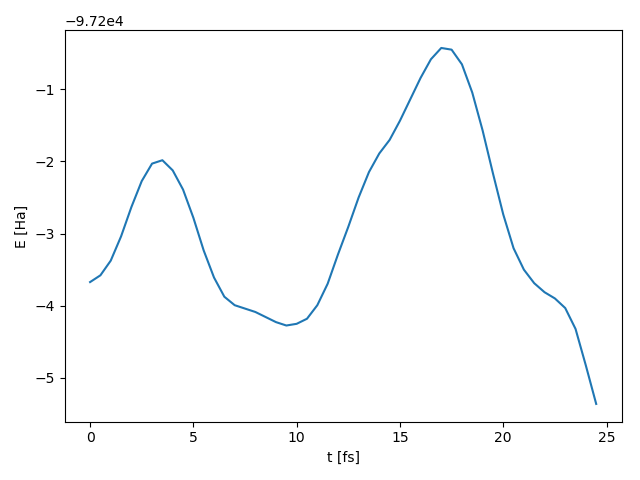

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt
from schnetpack.md.utils import MDUnits

# Get potential energies and check the shape
energies = data.get_property(Properties.energy)
print('Shape:', energies.shape)

# Get the time axis
time_axis = np.arange(data.entries)*data.time_step / MDUnits.fs2atu # in fs

# Plot the energies 
plt.figure()
plt.plot(time_axis, energies)
plt.ylabel('E [Ha]')
plt.xlabel('t [fs]')
plt.tight_layout()
plt.show()

The `HDF5Loader` also offers access to functions for computing some derived properties, such as the kinetic energy (`get_kinetic_energy`) and the temperature (`get_temperature`).

<IPython.core.display.Javascript object>


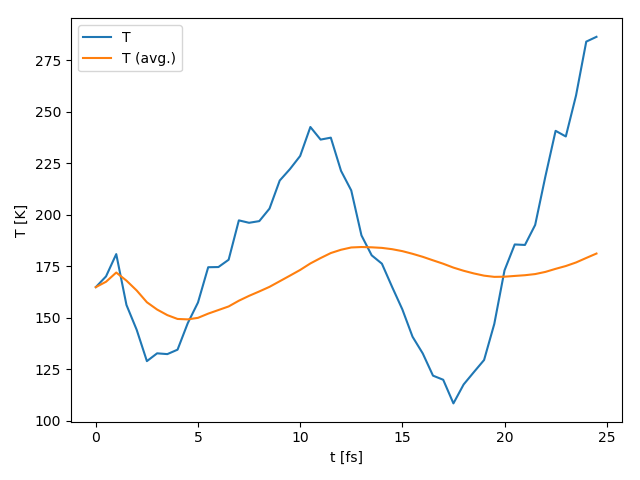

In [20]:
import numpy as np

# Read the temperature
temperature = data.get_temperature()

# Compute the cumulative mean
temperature_mean = np.cumsum(temperature) / (np.arange(data.entries)+1)

plt.figure()
plt.plot(time_axis, temperature, label='T')
plt.plot(time_axis, temperature_mean, label='T (avg.)')
plt.ylabel('T [K]')
plt.xlabel('t [fs]')
plt.legend()
plt.tight_layout()
plt.show()

It should be mentioned at this point, that the HDF5 datafile uses a special convention for units.
For internal quantities (e.g. positions, velocities and kinetic energy), atomic units are used.
The only exception are temperatures, which are given in units of Kelvin for convenience.
For all properties computed by the `Calculator` the original unit is used, unless a conversion factor is specified during initialization.
This means, that the energies and forces collected here have units of kcal/mol and kcal/mol/&#8491;.

### Power spectra

While curves of temperatures might be nice to look at, one is usually interested in different quantities when running a MD simulation.
One example are 

In [21]:
from schnetpack.md.utils import PowerSpectrum

spectrum = PowerSpectrum(data, resolution=4096)
spectrum.compute_spectrum(0)

INFO:root:Spectral resolutions:        2.036 [cm^-1]
INFO:root:Spectral range:          33356.410 [cm^-1]


<IPython.core.display.Javascript object>


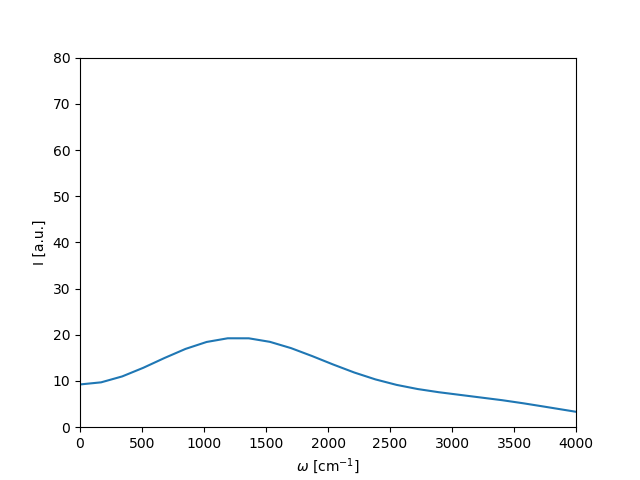

In [22]:
freq, inten = spectrum.get_spectrum()

plt.figure()
plt.plot(freq, inten)
plt.xlim(0,4000)
plt.ylim(0,80)
plt.ylabel('I [a.u.]')
plt.xlabel('$\omega$ [cm$^{-1}$]')
plt.show()

## Restarting simulations




## Ring polymer dynamics

Put here a spectrum comparison normal/rpmd

## Exploding molecules (Metadynamics)

Show an example where stuff migrates

## Quick setup with input files

## Summary

Future tutorials will cover, how to write custom calculators and hooks for performing your own simulations.